### Please keep in mind this is an initial, naive solution and is subject to drastic change.

In [4]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from anomalib.data.folder import Folder
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Additionally I modified the data in the following ways:
- I moved all the normal and abnomral instances into their own directories all together,
- I also removed any images with \*ref|Ref\* in their name that were in the abnormal/anomalous directories from being since they are from the refrence image, meaning they are what the client wants. You can verify this for yourselfes.
- To start you might also want to remove the images that are masked initially if you are only running this file, expect updates soon...

In [5]:
from anomalib.data.task_type import TaskType

cwd = Path.cwd()
parent_dir = cwd.parent

data_module = Folder(
    root=parent_dir / "Reels",
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.1,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    task=TaskType.CLASSIFICATION,
)
data_module.setup()
data_module.prepare_data()
i, data = next(enumerate(data_module.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [6]:
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


In [7]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [8]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        every_n_epochs=4,
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(Path.cwd()),
        filename="model",
        export_mode=ExportMode.TORCH,
    ),
]

In [10]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=4,
    devices=1,
    gpus=None,
    max_epochs=10,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PadimModel               | 2.8 M 
3 | image_metrics 

Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 12.68it/s, loss=nan, v_num=7, image_AUROC=0.618]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s, loss=nan, v_num=7, image_AUROC=0.618]


In [11]:
test_results = trainer.test(model=model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.6024668216705322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


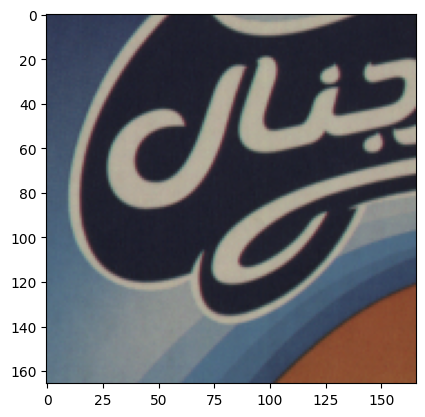

In [12]:
from matplotlib import pyplot as plt
imagepath = parent_dir / "Reels/normal/NRefSpot121.bmp"
image = read_image(imagepath)
plt.imshow(image)

In [13]:
abnormal_imagepath = parent_dir / "Reels/abnormal/YSpot48.bmp"
abnormal_image = read_image(abnormal_imagepath)
# plt.imshow(abnormal_imagepath)

In [19]:
# import torch
# model = model.load_from_checkpoint(Path.cwd() / 'lightning_logs/version_6/checkpoints/epoch=3-step=36.ckpt')
# model.laod_sta
mode_path = Path.cwd() / 'weights/torch/model.pt'
inferencer = TorchInferencer(path=mode_path)

In [20]:
print(image.shape)
predictions = inferencer.predict(image=image)
# type(predictions)
# predictions
predictions2 = inferencer.predict(image=abnormal_image)

(166, 166, 3)


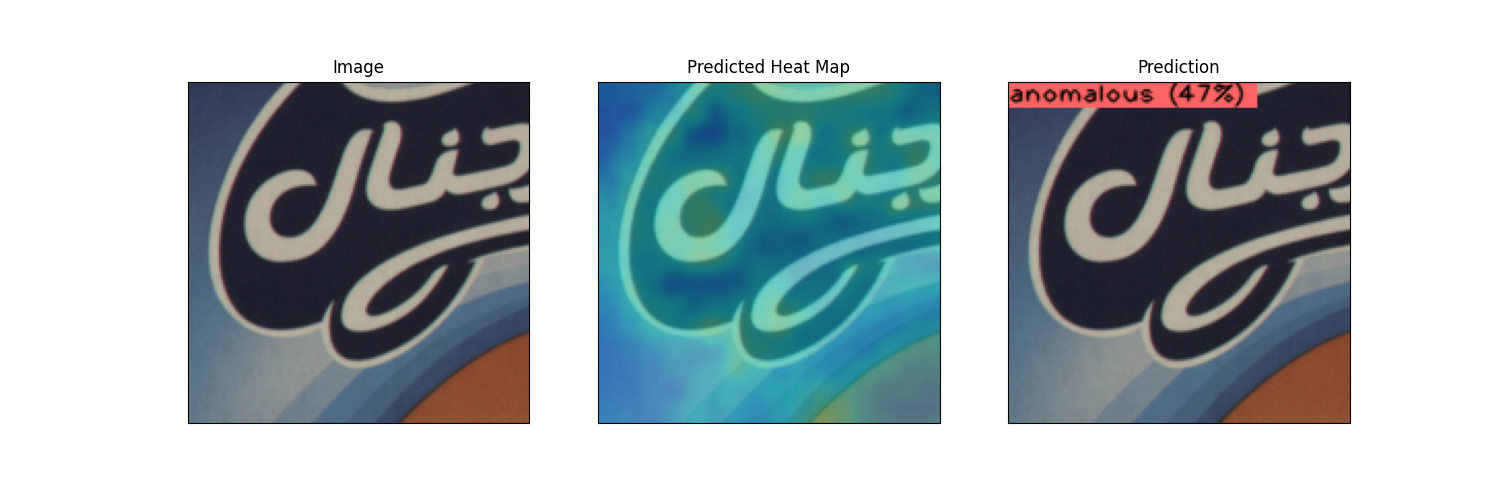

In [21]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

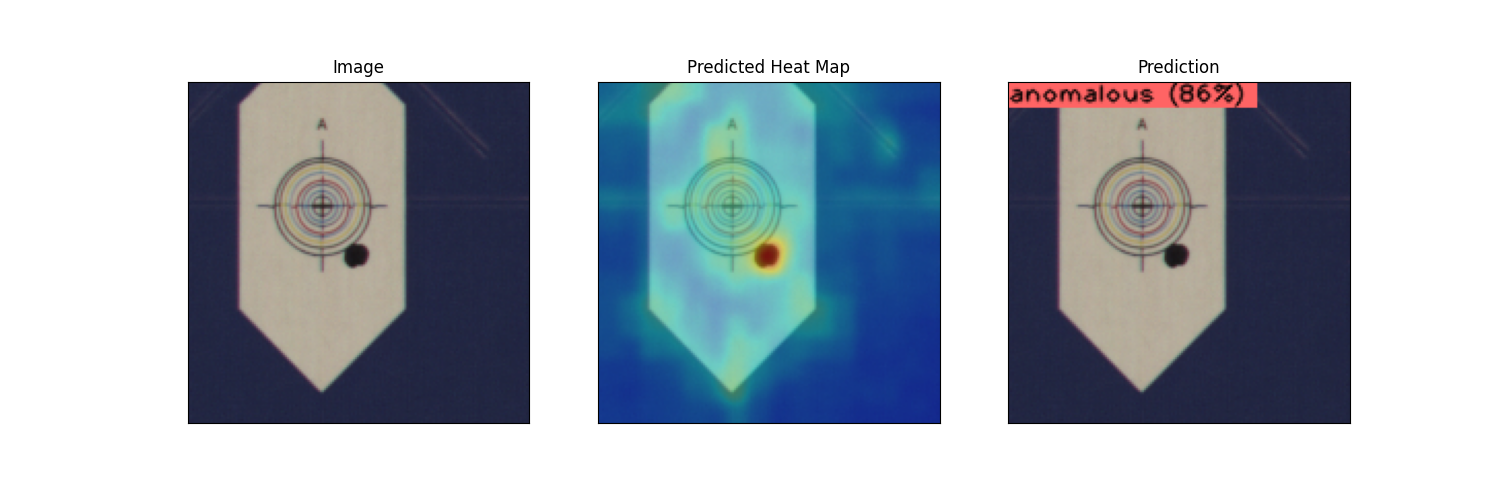

In [22]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions2)
Image.fromarray(output_image)